# BINARY CLASS CLASSIFICATION MODELS

In [ ]:
def Confusion_Matrix_PLOT(y_test,y_pred,class_Names, fName, ModelName):
    #Plot the confusion matrix to understand the classification in detail
    CM = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
    ax = sns.heatmap(CM, cmap='Greens', annot=True, fmt='d', xticklabels=class_Names, yticklabels=class_Names)
    plt.title(f'Alzheimer\'s Disease Diagnosis - {ModelName}')
    plt.xlabel('Prediction')
    plt.ylabel('Truth')
    plt.savefig(f"{Save_bin}{fName}")
    #plt.show(ax)

# Plot Evaluation Metrics
sns.set_style('darkgrid')
#plt.style.use('fivethirtyeight')
def Metric_Plot(acc,val_acc, loss,val_loss, auc, val_auc, precision, val_precision, path, title):
    
    fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4, figsize= (20,5))
    fig.suptitle(f"{title}\n", fontsize = 15)

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy', fontsize = 15)
    ax1.set_xlabel('Epochs', fontsize = 15)
    ax1.set_ylabel('Accuracy', fontsize = 15)
    ax1.legend(['Training', 'Validation'], fontsize = 15)


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss', fontsize = 15)
    ax2.set_xlabel('Epochs', fontsize = 15)
    ax2.set_ylabel('Loss', fontsize = 15)
    ax2.legend(['Training', 'Validation'], fontsize = 15)

    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC', fontsize = 15)
    ax3.set_xlabel('Epochs', fontsize = 15)
    ax3.set_ylabel('AUC', fontsize = 15)
    ax3.legend(['Training', 'Validation'], fontsize = 15)
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision', fontsize = 15)
    ax4.set_xlabel('Epochs', fontsize = 15)
    ax4.set_ylabel('Precision', fontsize = 15)
    ax4.legend(['Training', 'Validation'], fontsize = 15)

    plt.savefig(f"{Save_bin}{path}")

## ResNet50

In [ ]:
K.clear_session()

In [ ]:
ResNet50_base_bin = ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3),
)

ResNet50_base_bin.trainable = False

In [ ]:
for layer in ResNet50_base_bin.layers:
    layer.trainable=False

In [ ]:
# Building Top
ResNet50_Top_bin = Sequential()
ResNet50_Top_bin.add(ResNet50_base_bin)
ResNet50_Top_bin.add(GlobalAveragePooling2D())
ResNet50_Top_bin.add(Dense(128,activation='relu'))
ResNet50_Top_bin.add(Dropout(0.1))
ResNet50_Top_bin.add(Dense(1, activation='sigmoid'))

In [ ]:
ResNet50_Top_bin.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 23,850,113
Trainable params: 262,401
Non-trainable params: 23,587,712
______________________________________

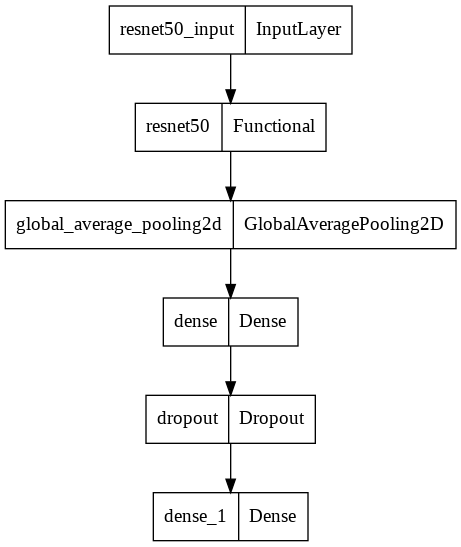

In [ ]:
plot_model(
    ResNet50_Top_bin,
    to_file=f"{Save_bin}ResNet50/Architecture.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
)


### ResNet50 Transfer Learning - Freeze base model

In [ ]:
METRICS = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),  
      keras.metrics.AUC(name='auc')
]


lr_reduce = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.4, 
    patience=5, 
    verbose=1, 
    mode='min', 
    min_lr=5e-5
    )

early_stopping_cb = EarlyStopping(
    monitor='val_loss', 
    patience=8, 
    restore_best_weights=True, 
    verbose=1, 
    mode="min"
    )

checkpoint_cb = ModelCheckpoint(
    f"{Save_bin}ResNet50/ResNet50_transferlearning.h5", 
    monitor='val_loss',
    save_best_only=True, 
    verbose=1, 
    mode="min"
    )

ResNet50_Top_bin.compile(
    optimizer=keras.optimizers.Adam(0.01), 
    loss='binary_crossentropy',
    metrics=METRICS,
)

epochs = 20
ResNet50_bin_history_1 = ResNet50_Top_bin.fit(
    training_data_bin, 
    epochs=epochs, 
    batch_size= 64,
    validation_data= validation_data_bin,
    steps_per_epoch= steps_per_epoch_bin,
    verbose = 1,
    callbacks = [lr_reduce, early_stopping_cb, checkpoint_cb],
    )

Epoch 1/20
64/64 [==============================] - ETA: 0s - loss: 1.5040 - accuracy: 0.5829 - precision: 0.5820 - recall: 0.5952 - auc: 0.5885
Epoch 1: val_loss improved from inf to 0.78518, saving model to drive/MyDrive/Pammy_Alzheimers_Disease_Prediction/Visualisation/BinaryClassification/ResNet50/ResNet50_transferlearning.h5
64/64 [==============================] - 26s 313ms/step - loss: 1.5040 - accuracy: 0.5829 - precision: 0.5820 - recall: 0.5952 - auc: 0.5885 - val_loss: 0.7852 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000 - val_auc: 0.8230 - lr: 0.0100
Epoch 2/20
64/64 [==============================] - ETA: 0s - loss: 0.6203 - accuracy: 0.6630 - precision: 0.6640 - recall: 0.6584 - auc: 0.7146
Epoch 2: val_loss improved from 0.78518 to 0.56745, saving model to drive/MyDrive/Pammy_Alzheimers_Disease_Prediction/Visualisation/BinaryClassification/ResNet50/ResNet50_transferlearning.h5
64/64 [==============================] - 18s 281ms/step - loss: 0.6203 - 

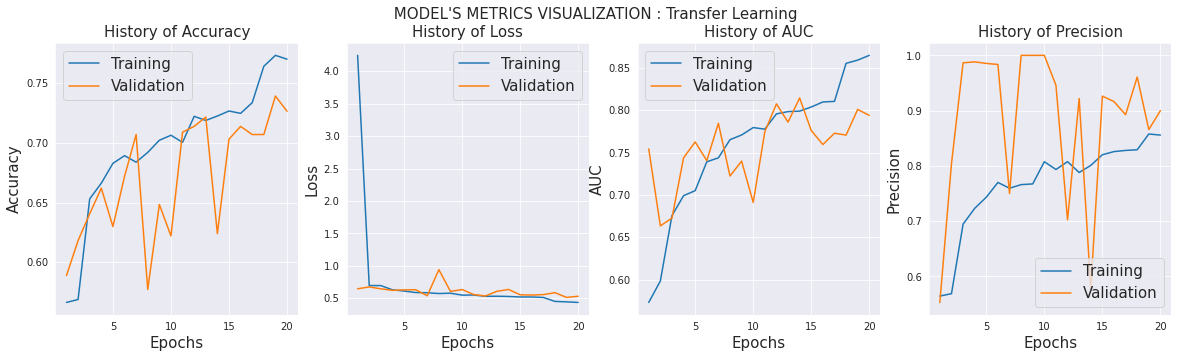

In [ ]:
path = "ResNet50/loss_acc_1.png"
title = " MODEL'S METRICS VISUALIZATION : Transfer Learning "
Metric_Plot(
    ResNet50_bin_history_1.history['accuracy'],ResNet50_bin_history_1.history['val_accuracy'],
    ResNet50_bin_history_1.history['loss'],ResNet50_bin_history_1.history['val_loss'],
    ResNet50_bin_history_1.history['auc'],ResNet50_bin_history_1.history['val_auc'],
    ResNet50_bin_history_1.history['precision'],ResNet50_bin_history_1.history['val_precision'],
    path, title
)

### ResNet50 finetuning - Unfreeze base model and train entire model with low learning rate

In [ ]:
isinstance(ResNet50_base_bin.layers[1], BatchNormalization)

False

In [ ]:
ResNet50_base_bin.trainable = True  
freeze_BN(ResNet50_base_bin)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


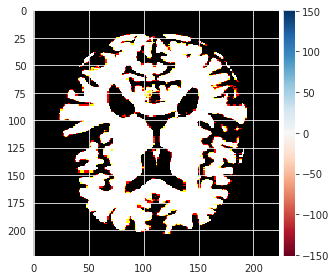

In [ ]:
imshow(training_data_bin[0][0][0])

In [ ]:
epochs = 50
ResNet50_Top_bin.compile(
    optimizer=keras.optimizers.RMSprop(0.005),  # Low learning rate
    loss='binary_crossentropy',
    metrics=METRICS,
)

ResNet50_Top_bin.summary()

ResNet50_bin_history_2 = ResNet50_Top_bin.fit(
    training_data_bin, 
    epochs=epochs, 
    validation_data=validation_data_bin, 
    verbose = 1, 
    steps_per_epoch=steps_per_epoch_bin,
    callbacks = [lr_reduce, early_stopping_cb, checkpoint_cb],
    )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 23,850,113
Trainable params: 23,743,873
Non-trainable params: 106,240
______________________________________

### Scores

In [ ]:
scores_ResNet50_bin = ResNet50_Top_bin.evaluate(testing_data_bin)

18/18 [==============================] - 3s 185ms/step - loss: 104697492525488966784151543873536.0000 - accuracy: 0.5829 - precision: 0.5829 - recall: 1.0000 - auc: 0.5000


In [ ]:
print(f"Accuracy in test set  : {scores_ResNet50_bin[1]}")
print(f"Precision in test set : {scores_ResNet50_bin[2]}")
print(f"Recall in test set    : {scores_ResNet50_bin[3]}")
print(f"AUC in test set       : {scores_ResNet50_bin[4]}")

Accuracy in test set  : 0.5828779339790344
Precision in test set : 0.5828779339790344
Recall in test set    : 1.0
AUC in test set       : 0.5


### Plots 

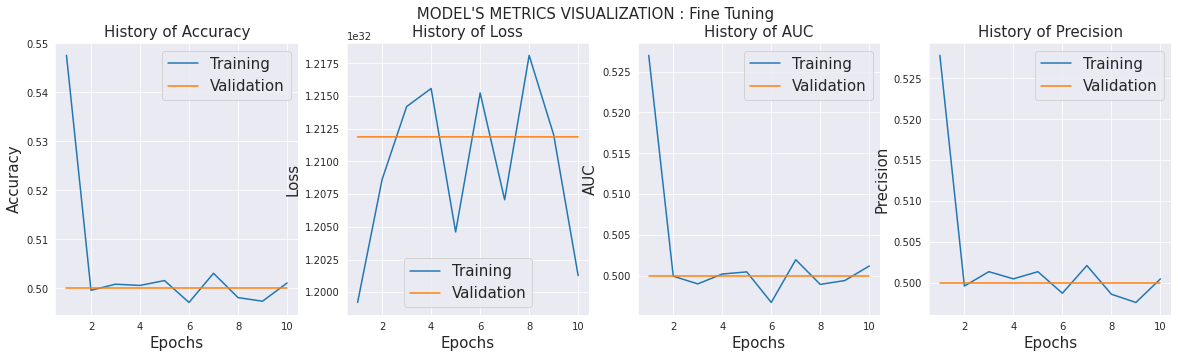

In [ ]:
path = "ResNet50/loss_acc_2.png"
title = " MODEL'S METRICS VISUALIZATION : Fine Tuning "
Metric_Plot(
    ResNet50_bin_history_2.history['accuracy'],ResNet50_bin_history_2.history['val_accuracy'],
    ResNet50_bin_history_2.history['loss'],ResNet50_bin_history_2.history['val_loss'],
    ResNet50_bin_history_2.history['auc'],ResNet50_bin_history_2.history['val_auc'],
    ResNet50_bin_history_2.history['precision'],ResNet50_bin_history_2.history['val_precision'],
    path, title
)

In [ ]:
predictions = ResNet50_Top_bin.predict(testing_data_bin) 
y_pred = predictions.argmax(axis = -1)
y_label = testing_data_bin.labels.copy()
class_Names = list(testing_data_bin.class_indices.keys())

In [ ]:
print(y_pred)
print(y_label)
print(f"{y_pred.shape} and {y_label.shape}")
print(class_Names)

[0 0 0 ... 0 0 0]
[0 0 0 ... 1 1 1]
(1098,) and (1098,)
['Demented', 'NonDemented']


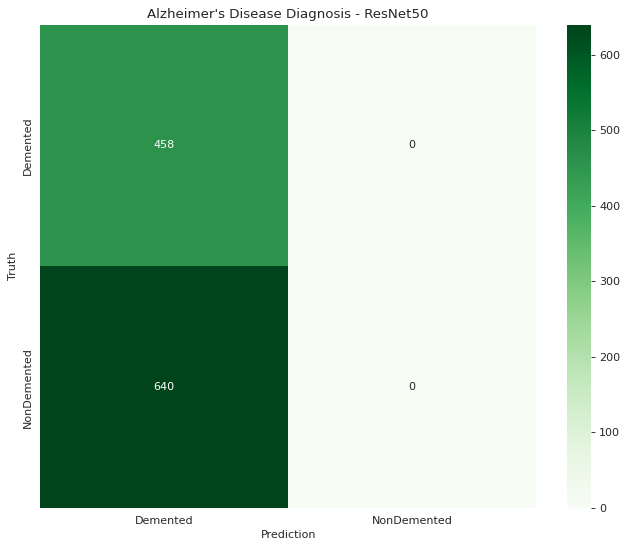

In [ ]:
Confusion_Matrix_PLOT(y_label, y_pred, class_Names, f"ResNet50/HeatMap.jpeg", "ResNet50")

## CNN - From Scratch

In [ ]:
K.clear_session()

In [ ]:
def conv_block(filters, act='relu'):
    """Defining a Convolutional NN block for a Sequential CNN model. """
    
    block = Sequential()
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(BatchNormalization())
    block.add(MaxPool2D())
    
    return block

def dense_block(units, dropout_rate, act='relu'):
    """Defining a Dense NN block for a Sequential CNN model. """
    
    block = Sequential()
    block.add(Dense(units, activation=act))
    block.add(BatchNormalization())
    block.add(Dropout(dropout_rate))
    
    return block

def construct_model(act='relu'):
    """Constructing a Sequential CNN architecture for performing the classification task. """
    
    model = Sequential([
        Input(shape=(224, 224, 3)),
        Conv2D(16, 3, activation=act, padding='same'),
        Conv2D(16, 3, activation=act, padding='same'),
        MaxPool2D(),
        conv_block(32),
        conv_block(64),
        conv_block(128),
        Dropout(0.2),
        conv_block(256),
        Dropout(0.2),
        Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        Dense(1, activation='sigmoid')        
    ], name = "cnn_model")

    return model

In [ ]:
Custom_CNN = construct_model()
Custom_CNN.summary()

Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 sequential (Sequential)     (None, 56, 56, 32)        14016     
                                                                 
 sequential_1 (Sequential)   (None, 28, 28, 64)        55680     
                                                                 
 sequential_2 (Sequential)   (None, 14, 14, 128)       221952    
                                                         

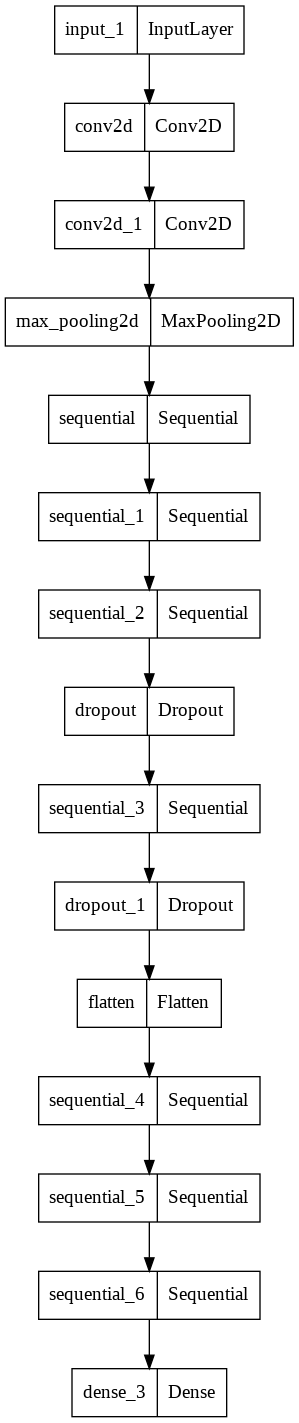

In [ ]:
plot_model(
    Custom_CNN,
    to_file=f"{Save_bin}CustomCNN/Architecture.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
)


In [ ]:
epochs = 50

METRICS = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),  
      keras.metrics.AUC(name='auc')
]

lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=5, verbose=1, mode='max', min_lr=5e-5)

early_stopping_cb = EarlyStopping(
    monitor='val_loss', 
    patience=8, 
    restore_best_weights=True, 
    verbose=1, 
    mode="max"
    )

checkpoint_cb = ModelCheckpoint(
    f"{Save_bin}CustomCNN/CustomCNN.h5", 
    monitor='val_loss',
    save_best_only=True, 
    verbose=1, 
    mode="max"
    )

Custom_CNN.compile(
    optimizer=keras.optimizers.RMSprop(0.0001),  # Low learning rate
    loss='binary_crossentropy',
    metrics=METRICS,
)

Custom_CNN_history = Custom_CNN.fit(
    training_data_bin, 
    epochs=epochs, 
    validation_data=validation_data_bin, 
    verbose = 1, 
    steps_per_epoch=steps_per_epoch_bin,
    callbacks = [lr_reduce, early_stopping_cb, checkpoint_cb],
    )

Epoch 1/50
64/64 [==============================] - ETA: 0s - loss: 0.8743 - accuracy: 0.5632 - precision: 0.5650 - recall: 0.5481 - auc: 0.5852
Epoch 1: val_loss improved from -inf to 0.77664, saving model to drive/MyDrive/Pammy_Alzheimers_Disease_Prediction/Visualisation/BinaryClassification/CustomCNN/CustomCNN.h5
64/64 [==============================] - 22s 280ms/step - loss: 0.8743 - accuracy: 0.5632 - precision: 0.5650 - recall: 0.5481 - auc: 0.5852 - val_loss: 0.7766 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6429 - lr: 1.0000e-04
Epoch 2/50
64/64 [==============================] - ETA: 0s - loss: 0.8115 - accuracy: 0.5988 - precision: 0.5987 - recall: 0.5855 - auc: 0.6308
Epoch 2: val_loss improved from 0.77664 to 0.87482, saving model to drive/MyDrive/Pammy_Alzheimers_Disease_Prediction/Visualisation/BinaryClassification/CustomCNN/CustomCNN.h5
64/64 [==============================] - 17s 263ms/step - loss: 0.8115 - accuracy: 0.5988 

### Plot

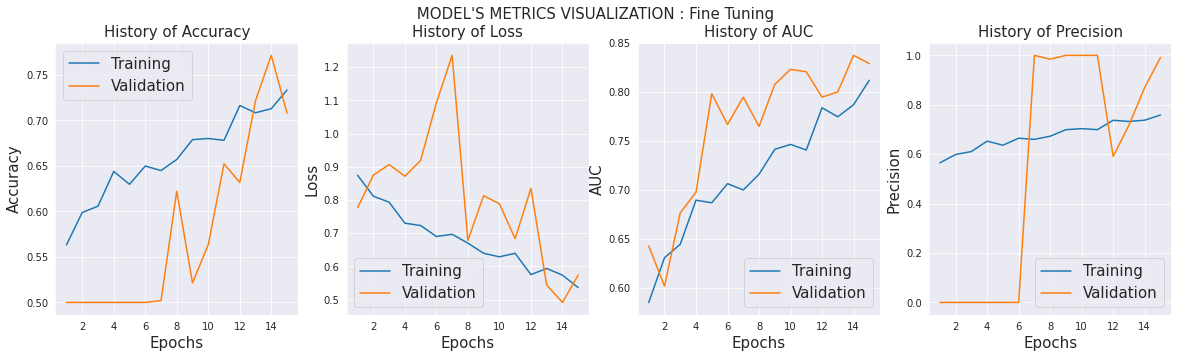

In [ ]:
path = "CustomCNN/loss_acc_2.png"
title = " MODEL'S METRICS VISUALIZATION : Fine Tuning "
Metric_Plot(
    Custom_CNN_history.history['accuracy'],Custom_CNN_history.history['val_accuracy'],
    Custom_CNN_history.history['loss'],Custom_CNN_history.history['val_loss'],
    Custom_CNN_history.history['auc'],Custom_CNN_history.history['val_auc'],
    Custom_CNN_history.history['precision'],Custom_CNN_history.history['val_precision'],
    path, title
)

In [ ]:
predictions = Custom_CNN.predict(testing_data_bin) 
y_pred = predictions.argmax(axis = -1)
y_pred.shape

(1098,)

In [ ]:
y_label = testing_data_bin.labels.copy()
y_label.shape
#class_Names

(1098,)

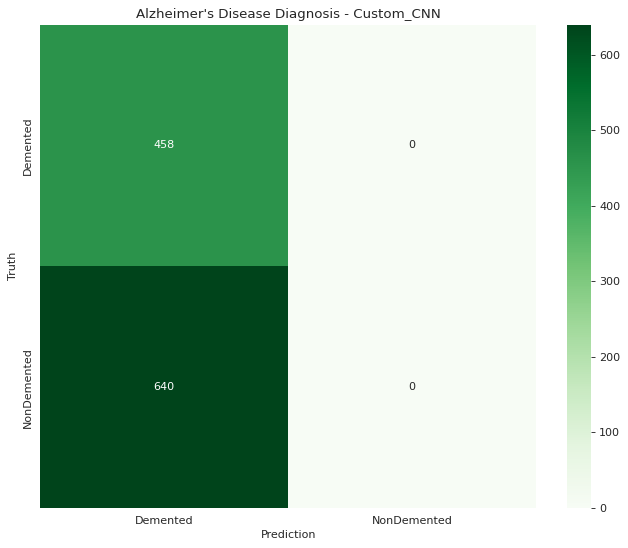

In [ ]:
Confusion_Matrix_PLOT(y_label, y_pred, class_Names, f"CustomCNN/HeatMap.jpeg", "Custom_CNN")

### Scores

In [ ]:
scores_Custom_CNN = Custom_CNN.evaluate_generator(testing_data_bin)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


In [ ]:
print(f"Accuracy in test set  : {scores_Custom_CNN[1]}")
print(f"Precision in test set : {scores_Custom_CNN[2]}")
print(f"Recall in test set    : {scores_Custom_CNN[3]}")
print(f"AUC in test set       : {scores_Custom_CNN[4]}")

Accuracy in test set  : 0.4198542833328247
Precision in test set : 1.0
Recall in test set    : 0.004687500186264515
AUC in test set       : 0.7857924699783325


# GradCam, activation Visualisation

In [ ]:
# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

## Configurable parameters

In [ ]:
Inception_Extention.summary()

In [ ]:
last_conv_layer_name = "conv2d_9"
decode_predictions = keras.applications.inception_v3.decode_predictions
X,y = testing_data.next()

In [ ]:
X[3].shape

(299, 299, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


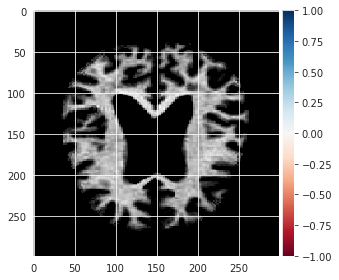

In [ ]:
img_path = X[0].copy()
imshow(X[3])

In [ ]:

def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our image array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def get_gradcam_img(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    return superimposed_img


In [ ]:
# Make model
model_load= keras.models.load_model(f"{Save}Inception/Inception.h5")

# Remove last layer's softmax
model_load.layers[-1].activation = None

In [ ]:
img_paths = []
for cls in class_Names:
  ClsPath2dir = f"{test}{cls}/"
  content = os.listdir(ClsPath2dir)
  imgPath = os.path.join(ClsPath2dir, np.random.choice(content))
  img_paths.append(imgPath)

img_paths


['drive/MyDrive/Pammy_Alzheimers_Disease_Prediction/Dataset/Alzheimers_Dataset/test/MildDemented/28 (23).jpg',
 'drive/MyDrive/Pammy_Alzheimers_Disease_Prediction/Dataset/Alzheimers_Dataset/test/ModerateDemented/29.jpg',
 'drive/MyDrive/Pammy_Alzheimers_Disease_Prediction/Dataset/Alzheimers_Dataset/test/NonDemented/32 (77).jpg',
 'drive/MyDrive/Pammy_Alzheimers_Disease_Prediction/Dataset/Alzheimers_Dataset/test/VeryMildDemented/28 (21).jpg']

Predicted : VeryMildDemented
Predicted : MildDemented
Predicted : NonDemented
Predicted : VeryMildDemented


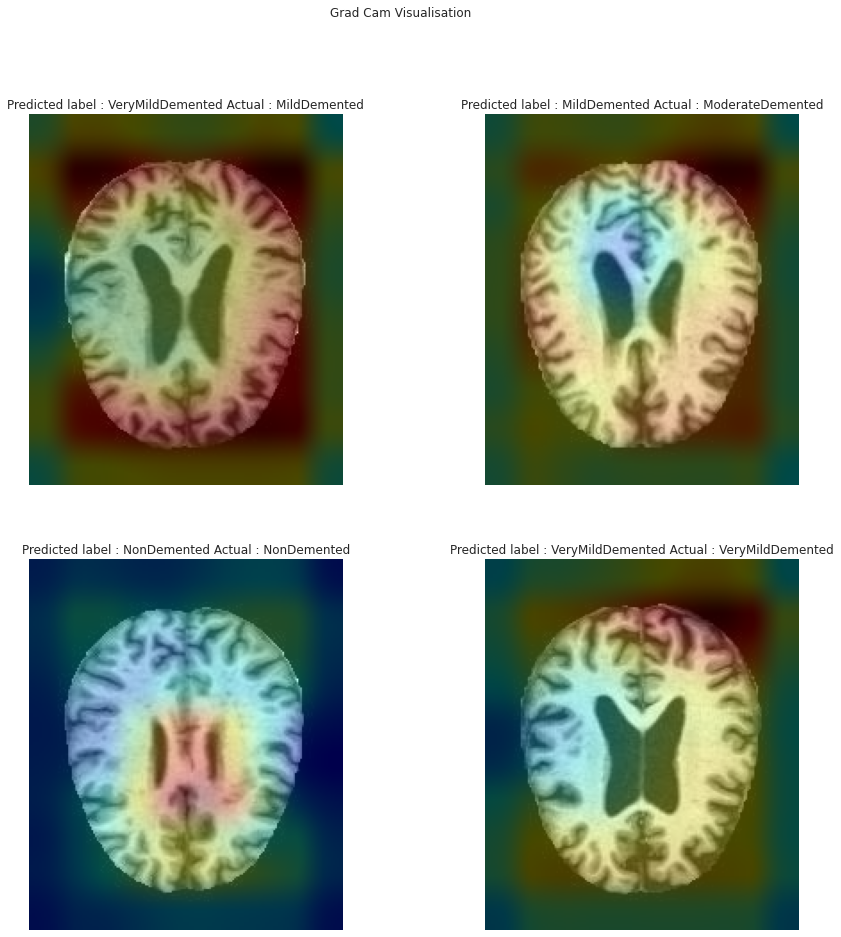

In [ ]:
fig, axs = plt.subplots(2, 2, figsize = (15,15))
for ax, path, label in zip(axs.flatten(), img_paths, class_Names): 
  # Prepare image
  img_arry = keras.applications.inception_v3.preprocess_input(get_img_array(path, (Image_Size, Image_Size)))
  # Print what the top predicted class is
  preds = model_load.predict(img_arry)
  print(f"Predicted : {Ind2ClassName[int(preds.argmax(axis=-1).squeeze())]}")
  #print("Predicted:", decode_predictions(preds, top=1)[0])

  # Generate class activation heatmap
  heatmap = make_gradcam_heatmap(img_arry, model_load, last_conv_layer_name)

  # Get superImposed Image
  superimposed_img = get_gradcam_img(path, heatmap)
  ax.imshow(superimposed_img)
  ax.axis('off')
  ax.title.set_text(f"Predicted label : {Ind2ClassName[int(preds.argmax(axis=-1).squeeze())]} Actual : {label}")

plt.suptitle('Grad Cam Visualisation')
plt.savefig(f"{Save}Inception/GradCam.jpg")
plt.show()
